In [1]:
import pandas as pd
import numpy as np

#Sklearn
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#Tesorflow / Keras
from tensorflow import keras
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import wordcloud
%matplotlib inline


Using TensorFlow backend.


In [2]:
data = pd.read_csv('spam.csv')

In [3]:
data = data[['v1','v2']]
data = data.rename(columns = {'v1': 'label', 'v2':'text'})

Main objectives of this notebook is to:
* Do data exploration on text data
* Practice on desining deeplearning architechture (RNN) 
* Train simple deep learning model for spam Detection
* Evaluate model performance

# I) Data exploration

In [4]:
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


* Number of spam and ham

In [5]:
data.groupby("label").describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

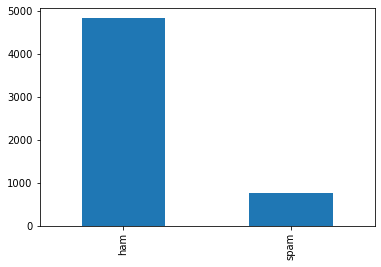

In [6]:
data.label.value_counts().plot.bar()

In [7]:
data['length'] = data['text'].apply(len)

* Length analysis
* It looks like Spam has longer lenght than Ham

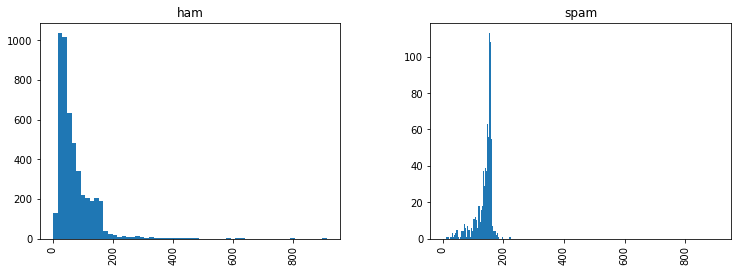

In [8]:
data.hist(column='length',by='label',bins=60,figsize=(12,4));
plt.xlim(-40,950);

* Word cloud for ham and spam

In [9]:
data_ham  = data[data['label'] == 'ham'].copy()
data_spam = data[data['label'] == 'spam'].copy()

In [10]:
def show_wordcloud(data_spam_or_ham, title):
    text = ' '.join(data_spam_or_ham['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

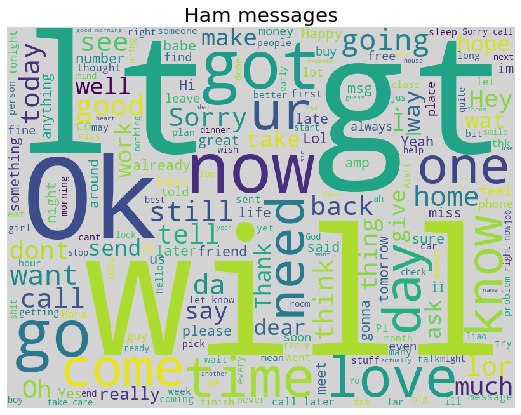

In [11]:
show_wordcloud(data_ham, "Ham messages")

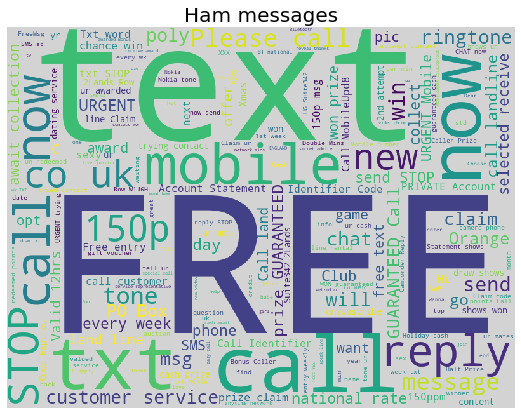

In [12]:
show_wordcloud(data_spam, "Ham messages")

# II) RNN for spam classification 

In [13]:
X = data.text
Y = data.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [14]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [15]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

* Let's try a simple RNN model with LSTM

In [16]:
BATCH_SIZE = 128
EPOCH = 10

In [17]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    
    model = keras.Sequential()
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model.add(layers.Embedding(input_dim=max_words, output_dim=64))

    model.add(layers.LSTM(64))

    model.add(layers.Dense(256))

    model.add(layers.Activation('relu'))

    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1))

    model.add(layers.Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics= METRICS)
    
    return model

In [18]:
model = make_model()

In [19]:
model_history = model.fit(sequences_matrix,Y_train,batch_size=BATCH_SIZE,epochs=EPOCH, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 3788 samples, validate on 948 samples
Epoch 1/10
3788/3788 [==============================] - 9s 2ms/sample - loss: 0.4679 - tp: 11.0000 - fp: 81.0000 - tn: 3204.0000 - fn: 492.0000 - accuracy: 0.8487 - precision: 0.1196 - recall: 0.0219 - auc: 0.5831 - val_loss: 0.3126 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 816.0000 - val_fn: 132.0000 - val_accuracy: 0.8608 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9509
Epoch 2/10
3788/3788 [==============================] - 5s 1ms/sample - loss: 0.1691 - tp: 251.0000 - fp: 6.0000 - tn: 3279.0000 - fn: 252.0000 - accuracy: 0.9319 - precision: 0.9767 - recall: 0.4990 - auc: 0.9735 - val_loss: 0.1098 - val_tp: 106.0000 - val_fp: 2.0000 - val_tn: 814.0000 - val_fn: 26.0000 - val_accuracy: 0.9705 - val_precision: 0.9815 - val_recall: 0.8030 - val_auc: 0.9724
Epoch 3/10
3788/3788 [==============================] - 5s 1ms/sample - loss: 0.0504 - tp: 460.0000 - fp: 13.0000 - tn: 3272.0000 - fn: 43.0000 - accuracy

* Training history visualisation

In [22]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
        plt.ylim([0.8,1])
    else:
        plt.ylim([0,1])

    plt.legend()

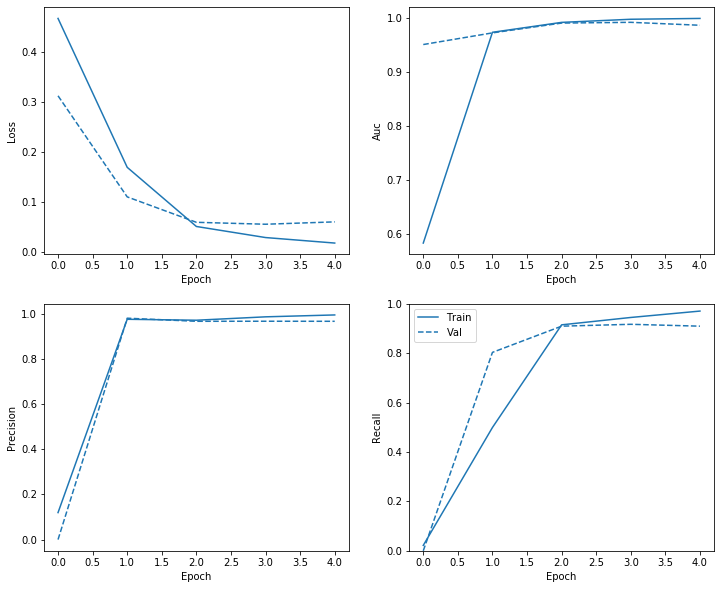

In [23]:
plot_metrics(model_history)

* Confusion matrix and ROC Curve

In [63]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [55]:
train_predictions = model.predict(sequences_matrix)
test_predictions = model.predict(test_sequences_matrix)

In [51]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Ham texts Detected (True Negatives): ', cm[0][0])
    print('Ham texts Incorrectly Detected (False Positives): ', cm[0][1])
    print('Spam texts Missed (False Negatives): ', cm[1][0])
    print('Spam texts Detected (True Positives): ', cm[1][1])
    print('Total spam: ', np.sum(cm[1]))

loss :  0.040950674813187295

tp :  88.0

fp :  6.0

tn :  736.0

fn :  6.0

accuracy :  0.98564595

precision :  0.9361702

recall :  0.9361702

auc :  0.9960357

Ham texts Detected (True Negatives):  736
Ham texts Incorrectly Detected (False Positives):  6
Spam texts Missed (False Negatives):  6
Spam texts Detected (True Positives):  88
Total spam:  94


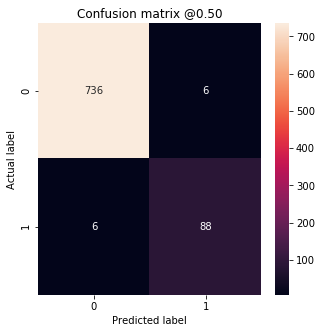

In [52]:
baseline_results = model.evaluate(test_sequences_matrix, Y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
    print()

plot_cm(Y_test, test_predictions)

In [53]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

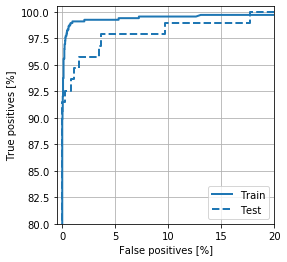

In [60]:
plot_roc("Train", Y_train, train_predictions, color=colors[0])
plot_roc("Test", Y_test, test_predictions, color=colors[0], linestyle='--')
plt.legend(loc='lower right')